# <font color = 'purple'> Predicting Energy Consumption Demand in Spain
    
    A Python application predicting energy consumption in Spain, using different time-series analysis methods (Random Forest, SARIMA, TBATS, PROPHET) on 4 years of hourly data

We are going to take the following approach:

1. Problem Definition
2. Data
3. Evaluation 
4. Features
5. Modelling
6. Experimentation

## <font color='green'> 1. Problem definition
    
In a statement

>Given hourly consumption data, how well can we predict the demand consumption for the next year?

## <font color ='green'> 2. Data

>This data is from Kaggle. 
>Link: https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather

## <font color = 'green'> 3. Evaluation
    
> Mean Absolute Error, Mean Square Error are the popular metrics for time series analysis..

## <font color = 'green'> 4. Data Dictionarity

**Create data dictionary**
* Time: Datetime index localized to CET
* total load actual: actual electrical demand in MWh

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from fbprophet import Prophet
from pmdarima import auto_arima
from tbats import TBATS, BATS


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Exploration
### <font color = 'green'>Load the data into the dataframe

In [58]:
df = pd.read_csv('energy.csv')
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [59]:
# Check dataframe shape
df.shape

(35064, 29)

<font color = 'green'>**We just need to work with the total load actual column for time series analysis. So we will drop all unrelated columns**

In [60]:
energy = df[['time','total load actual']]

In [61]:
# Remove the +01:00 from time
energy['time'] = energy['time'].map(lambda x: str(x)[:-6])
energy['time'][:5]

0    2015-01-01 00:00:00
1    2015-01-01 01:00:00
2    2015-01-01 02:00:00
3    2015-01-01 03:00:00
4    2015-01-01 04:00:00
Name: time, dtype: object

In [62]:
# converting feature "time" to datatime format
energy['time'] = pd.to_datetime(energy['time'])
energy.dtypes

time                 datetime64[ns]
total load actual           float64
dtype: object

<font color = 'green'>**Setting the index for the dataframe**

In [63]:
# setting time as the index for the dataframe
energy = energy.set_index('time')
energy.head(3)

,total load actual
time,
2015-01-01 00:00:00,25385.0
2015-01-01 01:00:00,24382.0
2015-01-01 02:00:00,22734.0


In [64]:
# verifying the indices of the dataframe
energy.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq=None)

In [65]:
# Verifying for duplicate indexes in the dataframe
energy[energy.index.duplicated()]

,total load actual
time,
2015-10-25 02:00:00,19775.0
2016-10-30 02:00:00,19786.0
2017-10-29 02:00:00,19867.0
2018-10-28 02:00:00,19965.0


In [66]:
# Removing duplicate indexes from the dataframe
energy = energy[~energy.index.duplicated()]

In [67]:
# Correcting the frequency (freq) of data collection from None to hourly (H)
energy = energy.asfreq('H')
energy.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq='H')

In [68]:
energy.head()

,total load actual
time,
2015-01-01 00:00:00,25385.0
2015-01-01 01:00:00,24382.0
2015-01-01 02:00:00,22734.0
2015-01-01 03:00:00,21286.0
2015-01-01 04:00:00,20264.0


In [69]:
energy.isnull().sum()

total load actual    40
dtype: int64

#### <font color = 'green'>Missing value imputations

In [70]:
# Forward fill the dataframe
energy.ffill(inplace = True)
energy.isnull().sum()

total load actual    0
dtype: int64

#### <font color = 'green'> Visualizing Trend in Data using Rolling Means

In [71]:
# We can visualize for year 2015 first, so that it's easier to see
year = 2015
s_load = energy[energy.index.year == year]

In [72]:
# Rolling means for daily data
df_load_24h = s_load.rolling(window = 24, center = True,min_periods=1).mean()
df_load_24h.head(3)

,total load actual
time,
2015-01-01 00:00:00,21739.250000
2015-01-01 01:00:00,21923.384615
2015-01-01 02:00:00,22122.642857


In [73]:
# Rolling means for weekly data
df_load_7d = s_load.rolling(window = 24*7, center = True, min_periods=1).mean()
# Rolling means for monthly data
df_load_30d = s_load.rolling(window = 24*30, center = True, min_periods=1).mean()
# Rolling means for yearly data
df_load_365d = s_load.rolling(window = 24*365, center = True, min_periods=1).mean()

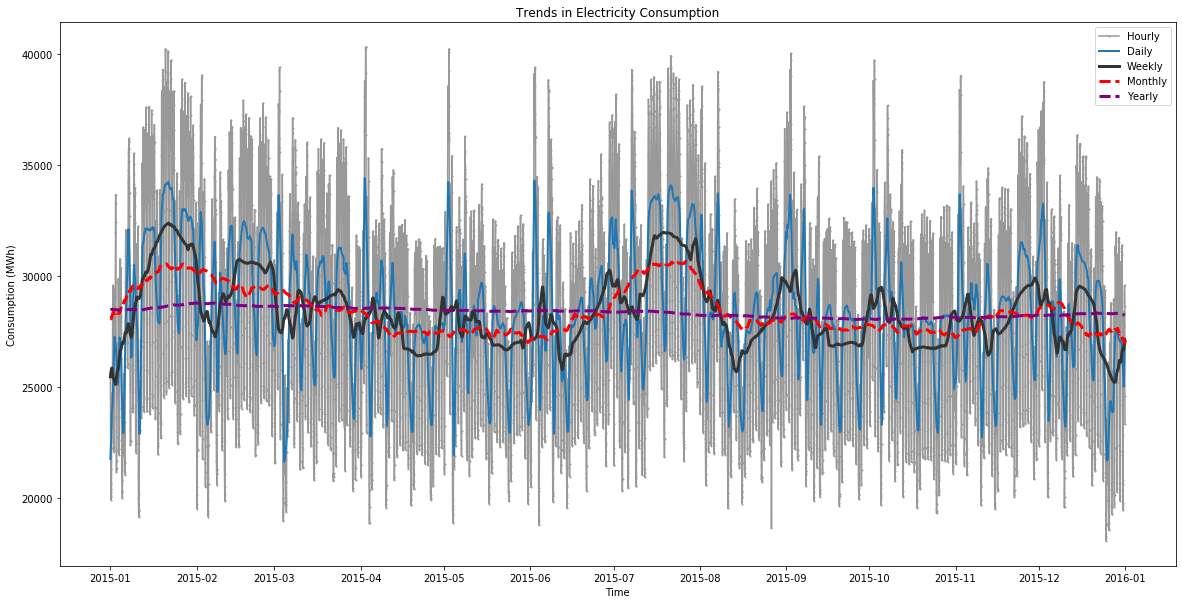

In [74]:
fig, ax = plt.subplots(figsize = (20,10))
# plotting hourly data
ax.plot(s_load, marker = '.', markersize = 2, color = '0.6', linestyle = None, label = 'Hourly')
# plotting daily data
ax.plot(df_load_24h, linewidth = 2, linestyle = "-", label = 'Daily')
# plotting 7-day trend
ax.plot(df_load_7d, linewidth = 3, color = '0.2', label = 'Weekly')
# plotting 30-day trend
ax.plot(df_load_30d, linewidth = 3,color = 'red', linestyle = '--', label = 'Monthly' )
# plotting 365-day trend
ax.plot(df_load_365d, linewidth = 3,color = 'purple', linestyle = '--', label = 'Yearly' )


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Consumption (MWh)')
ax.set_title('Trends in Electricity Consumption');

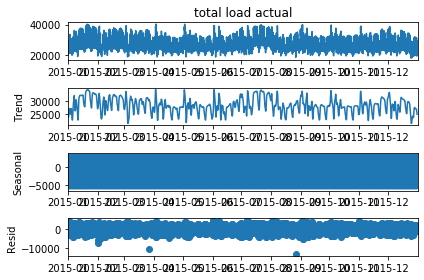

In [9]:
# Seasonality and Trend Check Test
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(energy.loc[energy.index.year==2015], model='additive');
result.plot();

#### <font color = 'green'> Visualizing Yearly trend in energy consumption
    The above graph is too difficult to see, we can see the data in more detail

In [75]:
# Rolling means for monthly data for all years
df_load_30d = energy.rolling(window = 24*30, center = True, min_periods=1).mean()
# Rolling means for yearly data
df_load_365d = energy.rolling(window = 24*365, center = True, min_periods=1).mean()

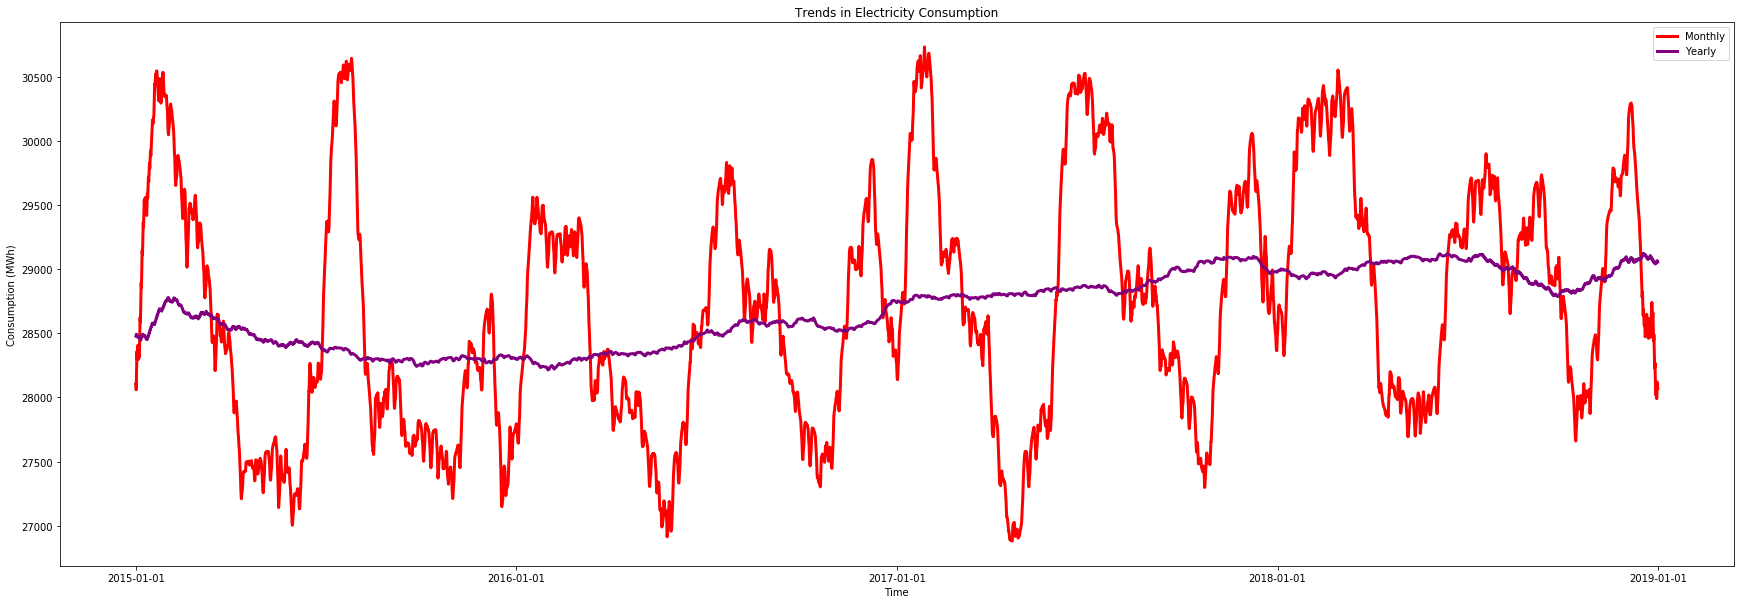

In [76]:
fig, ax = plt.subplots(figsize = (30,10))
# plotting 30-day trend
ax.plot(df_load_30d, linewidth = 3,color = 'red', linestyle = '-', label = 'Monthly' )
# plotting 365-day trend
ax.plot(df_load_365d, linewidth = 3,color = 'purple', linestyle = '-', label = 'Yearly' )
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Consumption (MWh)')
ax.set_title('Trends in Electricity Consumption');

#### Plot reveals data has a very slight upward trend and but it is not significant. But we see indication of yearly seasonality, with summer and winter months have higher consumption.

#### <font color = 'green'> Visualizing to see if we have Weekly seasonality in energy consumption

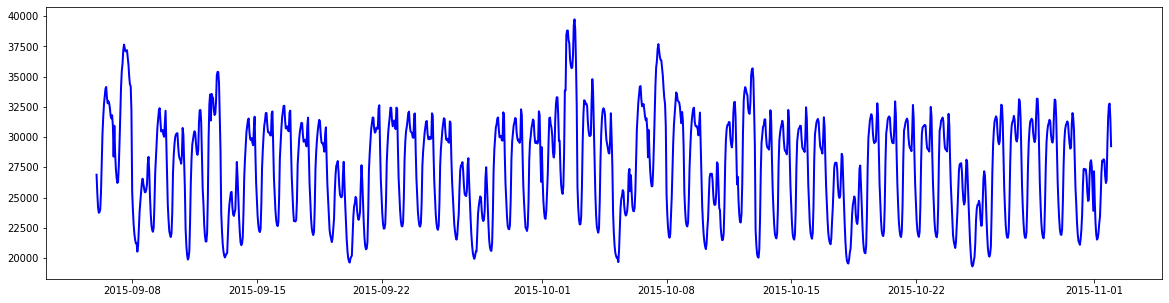

In [77]:
# Zoom in on hourly data for a random week
fig, ax = plt.subplots(figsize = (20,5))
# plotting hourly data (Sunday-Saturday)
ax.plot(s_load['2015-09-06':'2015-11-01'], linestyle = '-',linewidth = 2, color = 'blue', label = 'Weekly')

#### Plots shows weekly seasonality, with lowest consumption peaks on Saturdays and Sundays


### <font color = 'green'>Testing for Stationarity
We will use Dickey Fuller test for Stationarity

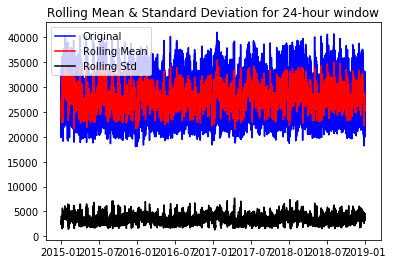

Results of Dickey-Fuller Test:
Test Statistic                   -21.473
p-value                            0.000
#Lags Used                        52.000
Number of Observations Used    35011.000
Critical Value (1%)               -3.431
Critical Value (5%)               -2.862
Critical Value (10%)              -2.567
dtype: float64


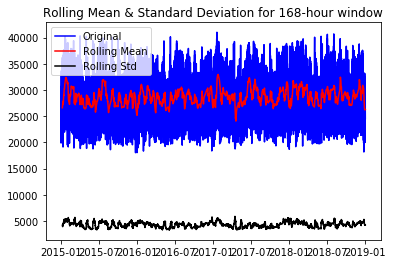

Results of Dickey-Fuller Test:
Test Statistic                   -21.473
p-value                            0.000
#Lags Used                        52.000
Number of Observations Used    35011.000
Critical Value (1%)               -3.431
Critical Value (5%)               -2.862
Critical Value (10%)              -2.567
dtype: float64


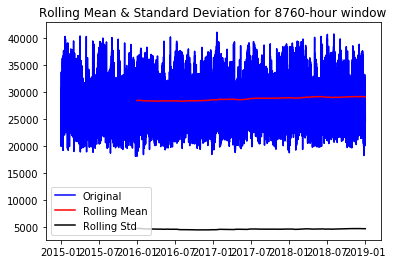

Results of Dickey-Fuller Test:
Test Statistic                   -21.473
p-value                            0.000
#Lags Used                        52.000
Number of Observations Used    35011.000
Critical Value (1%)               -3.431
Critical Value (5%)               -2.862
Critical Value (10%)              -2.567
dtype: float64


In [78]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,win):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win).mean()
    rolstd = timeseries.rolling(window=win).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for ' + str(win) + '-hour window')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
    
#runnning ADF test for different windows as seasonality is daily,weekly and yearly
window=[24,24*7,24*365]
for i in window:
    test_stationarity(energy,i)

**p-value is close to 0. Thus reject null hypothesis. The series is Stationary**

### <font color = 'green'> Plotting partial autocorrelation

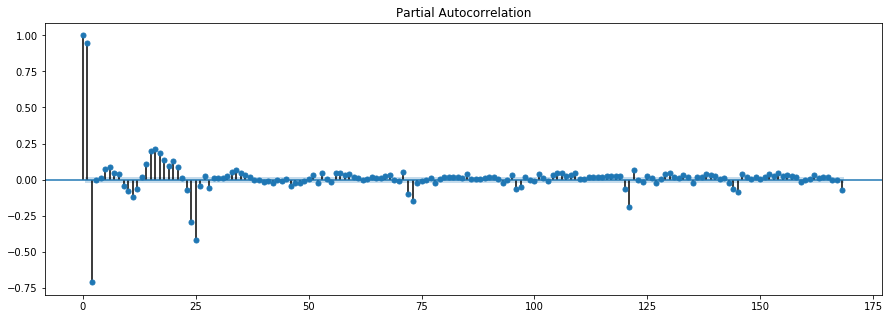

In [84]:
# importing statsmodel
from statsmodels.graphics.tsaplots import plot_pacf
# plotting the data partial autocorralation
fig, ax = plt.subplots(figsize = (15,5))
plot_pacf(energy['total load actual'].loc['2015-01':'2016-01'], ax = ax, lags=168, alpha = 0.05, method = 'ols');

**From partial autocorrelation plot, we see that lag-1, lag -2, lag-3, lag-24 is highly autocorrelated**

## Modelling
Use 1st 3 years to train and last year to test. We will try out first with regression models, then time series models

### <font color = 'purple'> 1. Regression models: Linear Reg, KNN, Random Forest

In [79]:
energy.head()

,total load actual
time,
2015-01-01 00:00:00,25385.0
2015-01-01 01:00:00,24382.0
2015-01-01 02:00:00,22734.0
2015-01-01 03:00:00,21286.0
2015-01-01 04:00:00,20264.0


In [80]:
# According to the above partial autocorrelation result, we will include lag 1, lag 2, lag 24, lag 168 in our model
energy_consumption = energy.copy()
energy_consumption.loc[:,'LastHourConsumption']=energy_consumption.shift()
energy_consumption.loc[:,'Last2hConsumption']=energy_consumption.shift(2)
energy_consumption.loc[:,'Last24hConsumption']=energy_consumption.shift(24)
energy_consumption.loc[:,'LastWeekConsumption']=energy.shift(24*7)
energy_consumption = energy_consumption.dropna()
energy_consumption.head()

,total load actual,LastHourConsumption,Last2hConsumption,Last24hConsumption,LastWeekConsumption
time,,,,,
2015-01-08 00:00:00,26788.0,30477.0,32697.0,30518.0,25385.0
2015-01-08 01:00:00,25146.0,26788.0,30477.0,28484.0,24382.0
2015-01-08 02:00:00,23889.0,25146.0,26788.0,27026.0,22734.0
2015-01-08 03:00:00,23046.0,23889.0,25146.0,26248.0,21286.0
2015-01-08 04:00:00,22587.0,23046.0,23889.0,25838.0,20264.0


### <font color = 'green'> Splitting Data

In [81]:
train_col=['LastHourConsumption',"Last2hConsumption","Last24hConsumption","LastWeekConsumption"]
X_train = energy_consumption.loc['2015-01-10':'2017-12-31'][train_col]
y_train = energy_consumption.loc['2015-01-10':'2017-12-31']['total load actual']

X_test = energy_consumption.loc[energy_consumption.index.year>=2018][train_col]
y_test = energy_consumption.loc[energy_consumption.index.year>=2018]['total load actual']
X_train.tail(3)

,LastHourConsumption,Last2hConsumption,Last24hConsumption,LastWeekConsumption
time,,,,
2017-12-31 21:00:00,28666.0,29097.0,29311.0,27618.0
2017-12-31 22:00:00,27260.0,28666.0,28286.0,25548.0
2017-12-31 23:00:00,25043.0,27260.0,26363.0,24598.0


### <font color = 'green'> Spot Check Algorithms

TimeSeriesSplit(max_train_size=None, n_splits=2)
LR: -622.358300 (3.381914)
TimeSeriesSplit(max_train_size=None, n_splits=2)
KNN: -706.217123 (13.229956)
TimeSeriesSplit(max_train_size=None, n_splits=2)
RF: -546.287509 (0.881970)


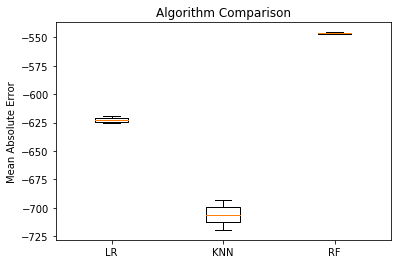

In [84]:
models=[('LR',LinearRegression()),
        ('KNN',KNeighborsRegressor()),
        ('RF',RandomForestRegressor(n_jobs = -1))]

names=[]
results=[]
for name,model in models:
    ts_crossval=TimeSeriesSplit(n_splits=2)
    cv_results = cross_val_score(model, X_train, y_train, cv=ts_crossval,
    scoring='neg_mean_absolute_error')
    print(ts_crossval)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.ylabel("Mean Absolute Error")
plt.title('Algorithm Comparison');

**Seems like Random Forest gives us the best result**

### <font color = 'green'> Find the best split for time series split

TimeSeriesSplit(max_train_size=None, n_splits=2)
RF_split_2: -597.218585 (16.660867)
TimeSeriesSplit(max_train_size=None, n_splits=24)
RF_split_24: -609.803636 (126.799322)
TimeSeriesSplit(max_train_size=None, n_splits=104)
RF_split_104: -597.274447 (177.208183)


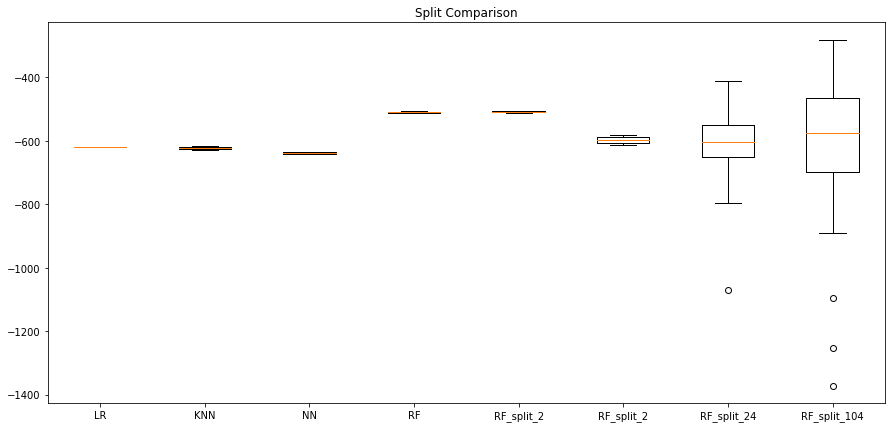

In [15]:
model=RandomForestRegressor()

split=[2,24,104]
for i in split:
    ts_crossval=TimeSeriesSplit(n_splits=i)
    cv_results = cross_val_score(model, X_train[X_train.index.year ==2015], y_train[y_train.index.year ==2015], cv=ts_crossval,
    scoring='neg_mean_absolute_error')
    print(ts_crossval)
    results.append(cv_results)
    names.append('RF_split_'+str(i))
    print('%s: %f (%f)' % ('RF_split_'+str(i), cv_results.mean(), cv_results.std()))
# Compare Algorithms

plt.figure(figsize=(15,7))
boxplot=plt.boxplot(results, labels=names)
plt.title('Split Comparison');

**Split 2 is the best result. This makes sense as we have 3 years in training data**

### <font color = 'green'> Hyperparameter Tuning 

In [86]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestRegressor(n_jobs = -1)
param_search = { 
    'n_estimators': np.arange(10,100,10),
    'max_depth' : [i for i in range(5,15)],
    'min_samples_split': np.arange(2,20,2),
    'min_samples_leaf': np.arange(1,20,2),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [10000]}

tscv = TimeSeriesSplit(n_splits=2)
tuned_model = RandomizedSearchCV(estimator=model,  
                             param_distributions=param_search, 
                             scoring = 'neg_mean_squared_error',
                             cv=tscv,
                             verbose = True,
                             random_state = 42)
tuned_model.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.8s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
                   estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=True)

In [88]:
tuned_model.best_estimator_

RandomForestRegressor(max_depth=14, max_features='log2', max_samples=10000,
                      min_samples_leaf=5, n_estimators=30, n_jobs=-1)

In [89]:
# Create function to evaluate model on a few different level
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {'Training MAE':mean_absolute_error(y_train, train_preds),
              'Test MAE':mean_absolute_error(y_test, test_preds),
              'Training MSE': mean_squared_error(y_train, train_preds),
              'Test MSE': mean_squared_error(y_test, test_preds),
             'Training R2': r2_score(y_train, train_preds),
             'Test R2': r2_score(y_test, test_preds)}
    return scores

In [90]:
show_scores(tuned_model)

{'Training MAE': 482.3043168134137,
 'Test MAE': 563.7399686475769,
 'Training MSE': 505537.2521968224,
 'Test MSE': 670610.4423509492,
 'Training R2': 0.9756048672200919,
 'Test R2': 0.9686646585664426}

In [91]:
# Plug in the best parameters
ideal_rf = RandomForestRegressor(max_depth=14, max_features='log2', max_samples=10000,
                      min_samples_leaf=5, n_estimators=30, n_jobs=-1)
ideal_rf.fit(X_train,y_train)
ideal_rf.feature_importances_

array([0.53285623, 0.30136618, 0.07478104, 0.09099655])

In [92]:
X_train.columns

Index(['LastHourConsumption', 'Last2hConsumption', 'Last24hConsumption',
       'LastWeekConsumption'],
      dtype='object')

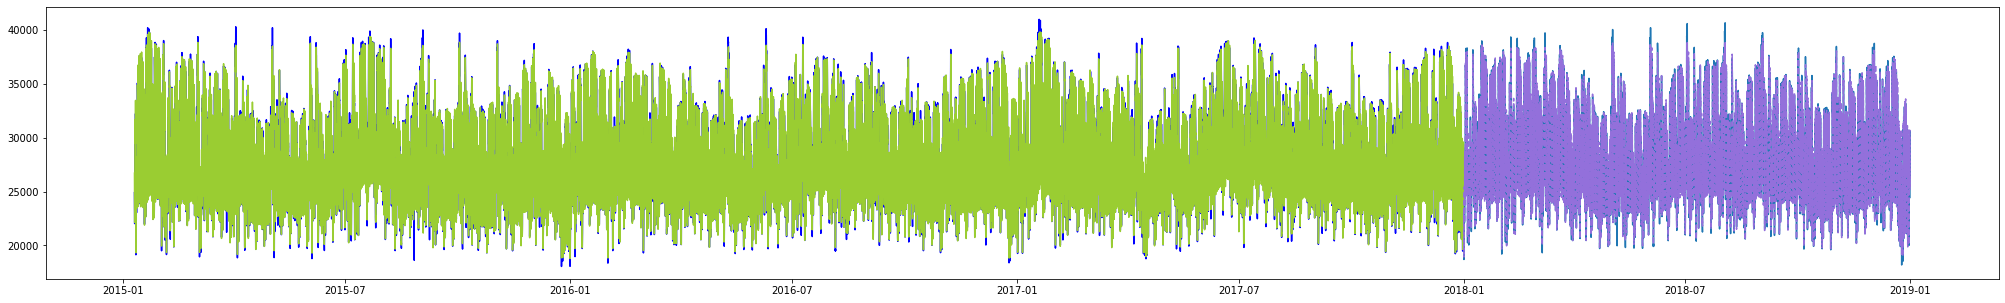

In [94]:
# Plot the regression's result please
train_preds = ideal_rf.predict(X_train)
test_preds = ideal_rf.predict(X_test)

# Predicted load on training data
train_preds = pd.Series(data = train_preds, index = X_train.index)
# Predicted load on test data
test_preds = pd.Series(data = test_preds, index = X_test.index)
# Plot data
fig, ax = plt.subplots(figsize = (35,5))

ax.plot(y_train, color = 'blue')
ax.plot(y_test)

ax.plot(train_preds, color = 'YellowGreen')
ax.plot(test_preds, linestyle = '--', color = 'MediumPurple');


**We have best metric result with Random Forest in all models**

### <font color = "purple"> 2. PROPHET

In [2]:
df=energy.copy()
df['date'] = df.index
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear

X = df[['hour','dayofweek','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']]
y=df['total load actual']
#X, y = create_features(energy['total load actual'], label='total load actual')

features_and_target = pd.concat([X, y], axis=1)

In [3]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,total load actual
time,,,,,,,,,
2015-01-01 00:00:00,0,3,1,1,2015,1,1,1,25385.0
2015-01-01 01:00:00,1,3,1,1,2015,1,1,1,24382.0
2015-01-01 02:00:00,2,3,1,1,2015,1,1,1,22734.0
2015-01-01 03:00:00,3,3,1,1,2015,1,1,1,21286.0
2015-01-01 04:00:00,4,3,1,1,2015,1,1,1,20264.0


In [4]:
features_and_target.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,total load actual
time,,,,,,,,,
2018-12-31 19:00:00,19,0,4,12,2018,365,31,1,30653.0
2018-12-31 20:00:00,20,0,4,12,2018,365,31,1,29735.0
2018-12-31 21:00:00,21,0,4,12,2018,365,31,1,28071.0
2018-12-31 22:00:00,22,0,4,12,2018,365,31,1,25801.0
2018-12-31 23:00:00,23,0,4,12,2018,365,31,1,24455.0


### <font color = 'green'> Visualize

In [5]:
split_date = '01-Jan-2018'
energy_train = features_and_target.drop(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
                                         'weekofyear'],axis=1).loc[energy.index <= split_date].copy()
energy_test = features_and_target.drop(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
                                         'weekofyear'],axis=1).loc[energy.index > split_date].copy()

In [6]:
#prophet needs dataset with specific column names 'ds' and 'y'

energy_train.reset_index(inplace=True)
energy_train.rename(columns={'time':'ds','total load actual':'y'},inplace=True)

In [7]:
energy_train.head()

,ds,y
0,2015-01-01 00:00:00,25385.0
1,2015-01-01 01:00:00,24382.0
2,2015-01-01 02:00:00,22734.0
3,2015-01-01 03:00:00,21286.0
4,2015-01-01 04:00:00,20264.0


In [ ]:
model=Prophet()
model.fit(energy_train)

In [38]:
energy_forecast=model.predict(df=energy_train)

In [55]:
energy_forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,28351.943578,22306.596812,29034.274706,28351.943578,28351.943578,-2858.263553,-2858.263553,-2858.263553,-2378.466796,...,961.417838,961.417838,961.417838,-1441.214595,-1441.214595,-1441.214595,0.0,0.0,0.0,25493.680025
1,2015-01-01 01:00:00,28351.964238,20638.491524,27129.867464,28351.964238,28351.964238,-4516.782979,-4516.782979,-4516.782979,-4026.708500,...,947.977551,947.977551,947.977551,-1438.052029,-1438.052029,-1438.052029,0.0,0.0,0.0,23835.181259
2,2015-01-01 02:00:00,28351.984898,19276.698726,26022.634743,28351.984898,28351.984898,-5670.629440,-5670.629440,-5670.629440,-5169.075573,...,933.270211,933.270211,933.270211,-1434.824078,-1434.824078,-1434.824078,0.0,0.0,0.0,22681.355459


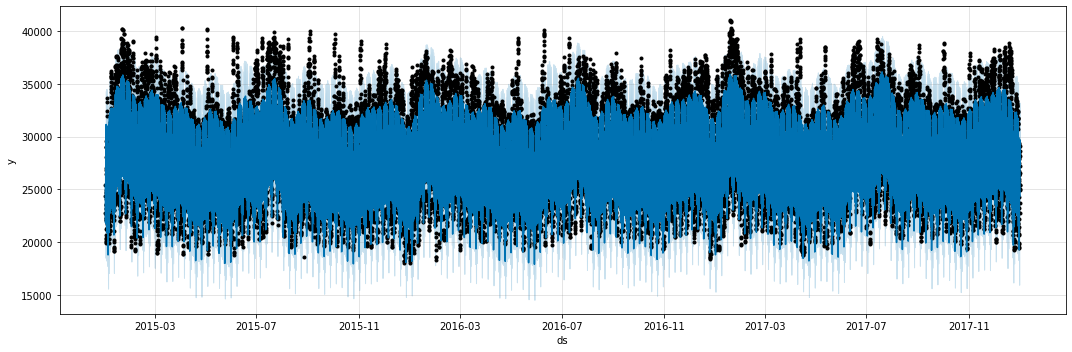

In [56]:
# Plot the forecast for training data
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(energy_forecast,
                 ax=ax)
plt.show()

In [39]:
energy_test.reset_index(inplace=True)
energy_test.rename(columns={'time':'ds','total load actual':'y'},inplace=True)
energy_test_forecast=model.predict(energy_test)

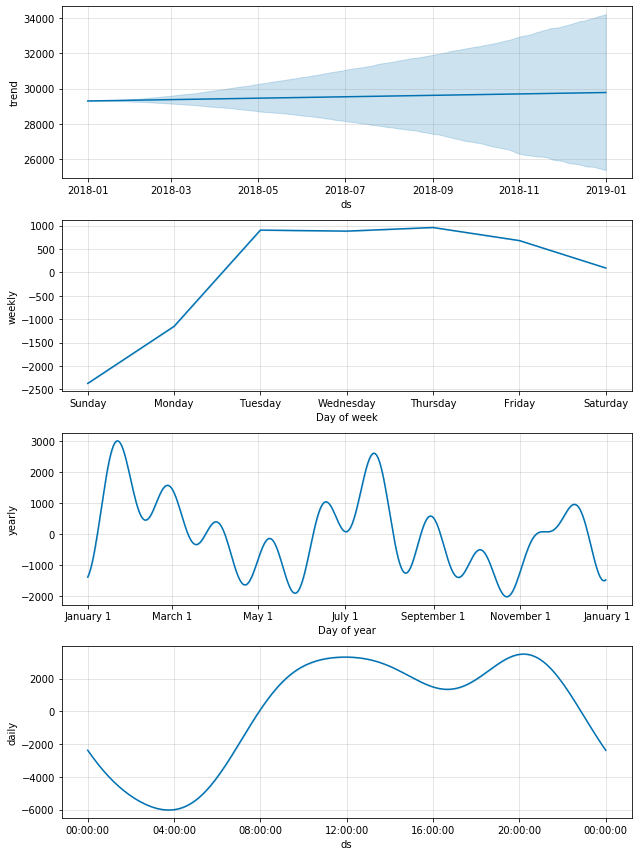

In [58]:
fig = model.plot_components(energy_test_forecast)

### <font color = 'green'> Forecast for 1st year

(736695.0, 737060.0)

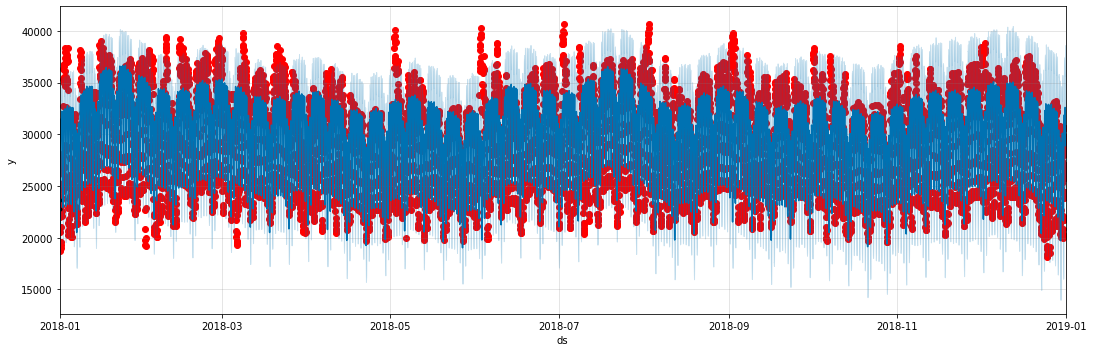

In [234]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(energy_test['ds'], energy_test['y'], color='r')
fig = model.plot(energy_test_forecast, ax=ax)
ax.set_xlim(['2018-01','2019-01'])

### <font color = 'green'> Forecast for 1st month

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(energy_test['ds'], energy_test['y'], color='r')
fig = model.plot(energy_test_forecast, ax=ax)
ax.set_xlim(['2018-01','2018-02'])
#red dots are actual data, blue line is the forecast, light blue shade is the confidence interval for the forecast

In [40]:
energy_test_forecast.set_index('ds',inplace=True)

In [41]:
energy_test_grouped=pd.merge(energy_test,energy_test_forecast[['yhat','yhat_lower','yhat_upper']],
                             left_on='ds',
                             right_on='ds',
                             how='inner')

In [42]:
energy_test_grouped.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-01 01:00:00,22009.0,22831.441617,19335.729573,26171.425774
1,2018-01-01 02:00:00,20589.0,21821.401122,18378.800183,25116.348532
2,2018-01-01 03:00:00,19547.0,21270.306193,17980.058668,24519.627264
3,2018-01-01 04:00:00,18871.0,21244.331424,17612.886508,24670.224560
4,2018-01-01 05:00:00,18688.0,21946.526936,18530.624227,25439.250505


In [43]:
energy_forecast.set_index('ds',inplace=True)
energy_train_grouped=pd.merge(energy_train,energy_forecast[['yhat','yhat_lower','yhat_upper']],
                             left_on='ds',
                             right_on='ds',
                             how='inner')
energy_train_grouped.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2015-01-01 00:00:00,25385.0,25493.680025,22537.473384,28840.216684
1,2015-01-01 01:00:00,24382.0,23835.181259,20455.244904,26984.187189
2,2015-01-01 02:00:00,22734.0,22681.355459,19487.492426,25896.608252
3,2015-01-01 03:00:00,21286.0,21985.854010,18614.653549,25306.224780
4,2015-01-01 04:00:00,20264.0,21815.804791,18312.177636,25303.209692


In [66]:
#metrics
from sklearn.metrics import mean_squared_error,r2_score
print('Mean Squared Error : %.2f'%mean_squared_error(y_true=energy_train_grouped['y'],
                   y_pred=energy_train_grouped['yhat']))
print('R2_score :%.2f'%r2_score(energy_train_grouped['y'],energy_train_grouped['yhat']))

Mean Squared Error : 6912833.19
R2_score :0.67


**Among all models, I like Prophet as it gives out upper and lower bound of prediction. This is very useful in business decision making process**

## Daily Data For Models: TBATS, SARIMA

Because our dataset is too big and my computer cannot run all of it with Tbats and Sarima. We will work with daily data here

In [9]:
# Sum of data
daily_load = energy['total load actual'].resample('D').sum()
daily_load.head()

time
2015-01-01    573522.0
2015-01-02    654031.0
2015-01-03    602656.0
2015-01-04    650703.0
2015-01-05    552644.0
Freq: D, Name: total load actual, dtype: float64

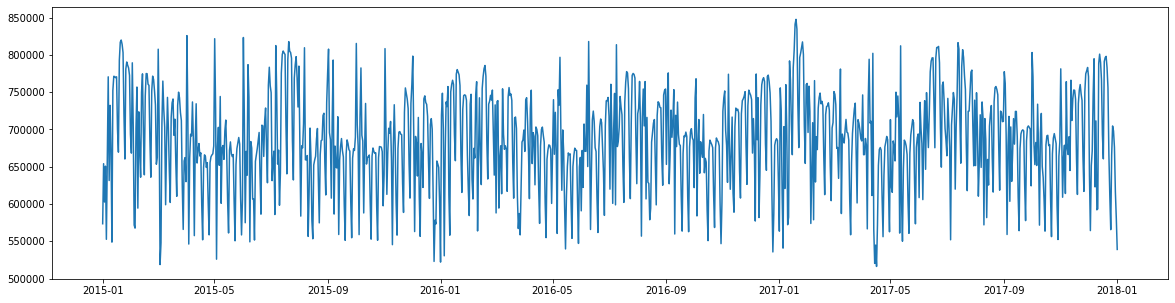

In [10]:
# Splitting data
split_date = "2018-01-01"
daily_train = daily_load[:split_date]
daily_test = daily_load[split_date:]
plt.subplots(figsize = (20,5))
plt.plot(daily_train)

## <font color = 'purple'> SARIMA

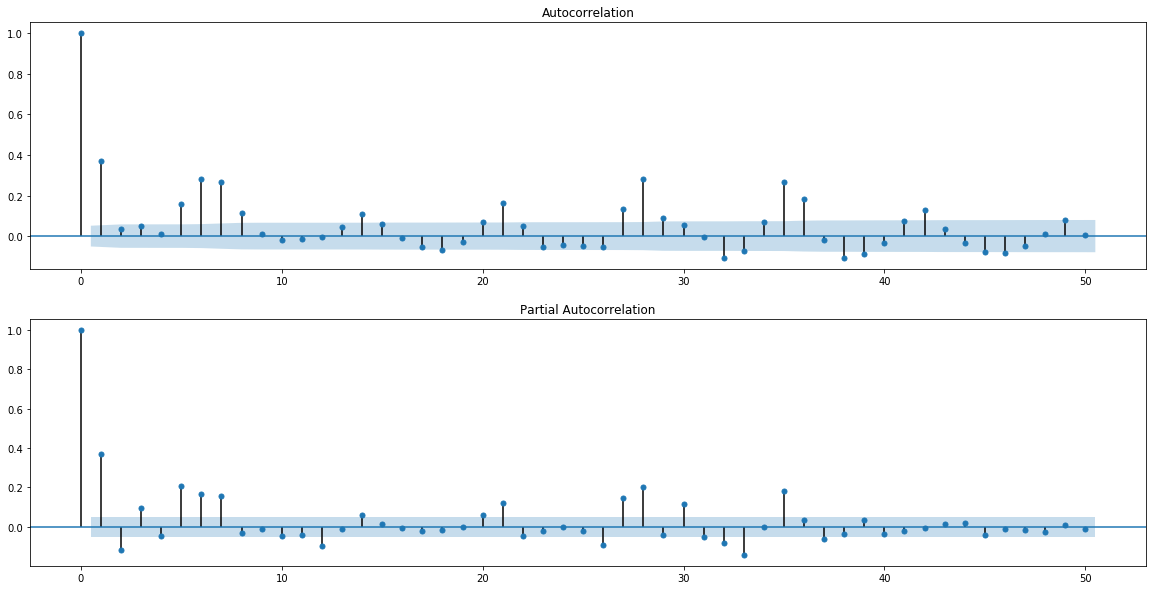

In [11]:
# Run ACF and PACF for daily data
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(daily_load, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(daily_load, lags=50, ax=ax[1])
plt.show()

In [5]:
# Choose the best lags (p,q)
resDiff = sm.tsa.arma_order_select_ic(daily_train, max_ar=8, max_ma=8, ic='aic')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (5, 4) is the best.


**Our dataset has multi-seasonalities, and regular SARIMA function only allows us to input 1 seasonality. The trick here is to include the yearly seaosnality in exogenous data. We have 2016 as a leap year so we will divide the day with 365.25 instead of 365.**

In [12]:
# prepare Fourier terms
exog = pd.DataFrame({'date': daily_load.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin30'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos30'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin30_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos30_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog.loc[:split_date]
exog_to_test = exog.loc[split_date:]
print(exog_to_train.shape)
exog_to_train.head()

(1097, 4)


,sin30,cos30,sin30_2,cos30_2
date,,,,
2015-01-01,0.017202,0.999852,0.034398,0.999408
2015-01-02,0.034398,0.999408,0.068755,0.997634
2015-01-03,0.051584,0.998669,0.103031,0.994678
2015-01-04,0.068755,0.997634,0.137185,0.990545
2015-01-05,0.085906,0.996303,0.171177,0.985240


In [13]:
# Fit model
arima_model = auto_arima(daily_train, exogenous=exog_to_train,
                         start_p=5, start_q=4,
                         max_p=5, max_q=4, seasonal=True, m=7)
# Forecast
y_arima_exog_forecast = arima_model.predict(n_periods=365, exogenous=exog_to_test)

In [14]:
print(arima_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1097
Model:             SARIMAX(5, 0, 4)x(0, 0, [1, 2], 7)   Log Likelihood              -13556.462
Date:                                Thu, 26 Nov 2020   AIC                          27146.925
Time:                                        10:58:48   BIC                          27231.931
Sample:                                    01-01-2015   HQIC                         27179.087
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.948e+05     23.209    1.7e+04      0.000    3.95e+05    3.95e+05
sin

In [19]:
print(arima_model.conf_int())

                      0             1
intercept  3.947374e+05  3.948284e+05
sin30     -8.805137e+03  8.563490e+03
cos30     -2.325543e+03  1.319665e+04
sin30_2    7.956422e+03  2.468101e+04
cos30_2    1.022665e+04  2.625862e+04
ar.L1      1.026620e+00  1.267246e+00
ar.L2     -9.633684e-01 -3.724779e-01
ar.L3     -5.810089e-01  1.394193e-01
ar.L4     -2.022050e-01  3.044400e-01
ar.L5      2.205852e-02  2.073961e-01
ma.L1     -9.757332e-01 -7.106560e-01
ma.L2      1.982579e-02  5.209620e-01
ma.L3      3.710298e-01  8.682041e-01
ma.L4     -2.942986e-01 -2.702591e-02
ma.S.L7    4.244832e-02  1.718035e-01
ma.S.L14  -1.114907e-01  3.510819e-02
sigma2     3.252994e+09  3.252994e+09


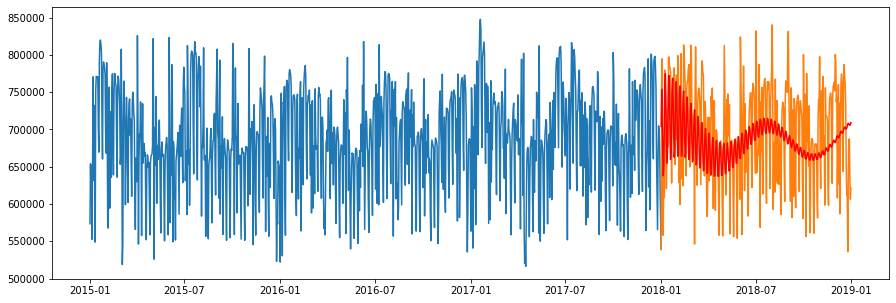

In [16]:
# Predicted load on test data
y_preds = pd.Series(data = y_arima_exog_forecast, index = daily_test.index)

# Plot data
fig, ax = plt.subplots(figsize = (15,5))
#ax.plot(arima_model.y_hat, color = 'blue')
ax.plot(daily_train)
ax.plot(daily_test)
ax.plot(y_preds, color = 'red');

In [18]:
def show_metrics(y_true, y_preds):
    scores = {'MAE':mean_absolute_error(y_true, y_preds),
              'MSE': mean_squared_error(y_true, y_preds),
              'R2': r2_score(y_true, y_preds)}
    return scores
              
show_metrics(daily_test, y_preds)

{'MAE': 54630.289649449005,
 'MSE': 4301793990.321909,
 'R2': 0.0017328987050304612}

**SARIMA does not scale well in long-term prediction**

## <font color = 'purple'> TBATS

In [19]:

# We have 2016 is a leap year so yearly seasonality is 365.25
estimator = TBATS(seasonal_periods=(7, 365.25))   #provide the different seasonalilties in seasonal_periods
tbats_model = estimator.fit(daily_load[:"2018-01-01"]) #processing time is too large for this dataset and 
# Forecast 365 days ahead
y_forecast = tbats_model.forecast(steps=365)
print(tbats_model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 4]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.151820
Seasonal Parameters (Gamma): [ 0.00190774  0.00104656  0.00432327 -0.00384274]
AR coefficients []
MA coefficients []
Seed vector [ 6.62139212e+05  2.51565943e+04 -3.92712359e+03 -4.00627389e+03
 -2.36826727e+04  1.72150585e+04 -7.34603415e+03  4.03627802e+03
  1.73682687e+04 -9.63167552e+03 -1.45507306e+03  1.95135198e+02
  1.59979522e+04 -3.32803458e+03  1.74731068e+03]

AIC 31724.647071


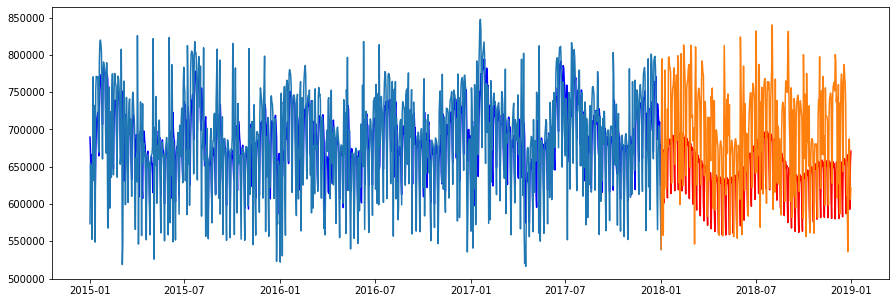

In [20]:
# Predicted load on training data
y_hat = pd.Series(data = tbats_model.y_hat, index = daily_train.index)
# Predicted load on test data
y_preds = pd.Series(data = y_forecast, index = daily_test.index)
# Plot data
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(y_hat, color = 'blue')
ax.plot(y_preds, color = 'red')
ax.plot(daily_train)
ax.plot(daily_test);

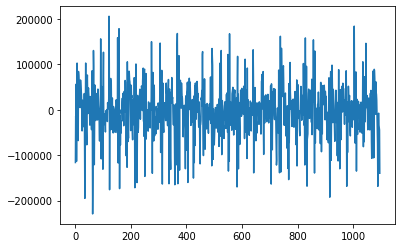

In [14]:
# Plot the resid
plt.plot(tbats_model.resid);

In [21]:
show_metrics(daily_train, y_hat)

{'MAE': 41107.56831231884, 'MSE': 3188007525.495207, 'R2': 0.2728351233410876}

In [22]:
show_metrics(daily_test, y_preds )

{'MAE': 75333.13038381858, 'MSE': 7612530873.301953, 'R2': -0.7665511518000272}

**TBATS well addressed the seasonalities, but the error is too large here, leading to serious overfit**